In [1]:
scores = '../out/ko_scores.txt'
dev = '../out/deviating.tsv'
sgd = '../out/SGD_features.tab'
biogrid = '../out/biogrid.all.txt'
biogrid_genetic = '../out/biogrid.genetic.txt'
# mutfunc = '../out/mutfunc_snps.tsv'

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib_venn import venn2, venn3

sns.set_style('white')

plt.rc('font', size=11)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=12, titlesize=12)
plt.rc('legend', fontsize=11)

In [3]:
import random
import numpy as np
import pandas as pd
import networkx as nx
from scipy import stats

In [4]:
# def logistic(score, slope, intercept):
#     return 1. / (1 + np.exp(-((slope * score) + intercept)))

# slope = 0.761
# intercept = 2.888
# offset = 1.59802721091e-05

# mut = pd.read_table(mutfunc)
# mut['p(neutral)'] = [logistic(-np.log(x + offset),
#                               slope, intercept)
#                      for x in mut['sift']]
# mut = mut[['strain',
#            'gene',
#            'p(neutral)']].dropna().groupby([
#           'strain',
#           'gene'])[
#           'p(neutral)'
#           ].apply(lambda x: 1 - np.prod(x))
# mut.name = 'P(AF)'

In [5]:
it = {}
for l in open(biogrid):
    g1, g2 = l.rstrip().split()
    it[g1] = it.get(g1, 0)
    it[g2] = it.get(g2, 0)
    it[g1] += 1
    it[g2] += 1

In [6]:
bg = nx.Graph()
for l in open(biogrid):
    g1, g2 = l.rstrip().split()
    bg.add_edge(g1, g2)
bc = nx.betweenness_centrality(bg, k=500)

In [7]:
g = pd.read_table(sgd, sep='\t', header=None)
gn = g[g[1] == 'ORF'].set_index(3)[4].dropna().to_dict()
gd = g[g[1] == 'ORF'].set_index(3)[15].dropna().to_dict()

In [8]:
gi = pd.read_table(biogrid_genetic)
git = {}
for g1, g2 in gi[(gi['interaction'] == 'negative') &
                 (gi['count'] >= 2)][['gene1', 'gene2']].values:
    git[g1] = git.get(g1, 0)
    git[g2] = git.get(g2, 0)
    git[g1] += 1
    git[g2] += 1
pit = {}
for g1, g2 in gi[(gi['interaction'] == 'positive') &
                 (gi['count'] >= 2)][['gene1', 'gene2']].values:
    pit[g1] = pit.get(g1, 0)
    pit[g2] = pit.get(g2, 0)
    pit[g1] += 1
    pit[g2] += 1

In [9]:
m = pd.read_table(scores, index_col=[0, 2, 1])
m['phenotype'] = m['qvalue'] < 0.05
genes = None
for s in {x[0] for x in m.index}:
    gs = {x[0] for x in m.loc[s].index}
    if genes is None:
        genes = gs
    else:
        genes = genes.intersection(gs)
    print(s, len(gs))
print('')
print('total', len(genes))
genes = sorted(genes)
p = m.reset_index().set_index('gene').loc[genes].groupby('condition').sum()['phenotype']

UWOP 4014
YPS 4093
Y55 4190
S288C 4889

total 3786


In [10]:
m = pd.read_table(dev)

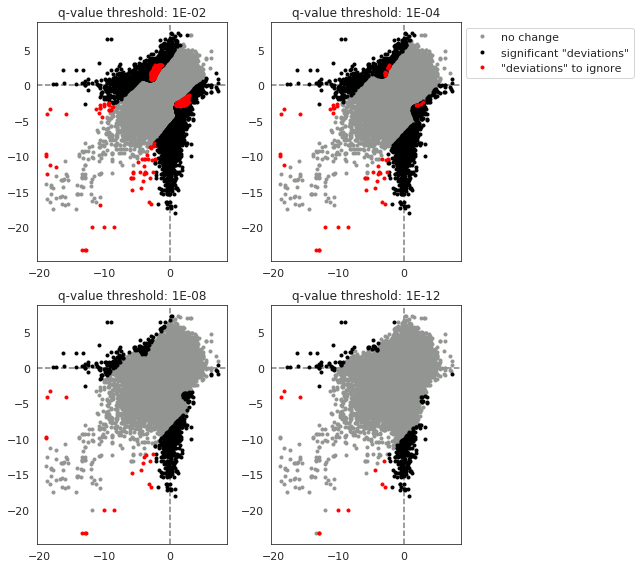

In [11]:
plt.figure(figsize=(9, 8))

for idx, pval in enumerate([1E-2, 1E-4, 1E-8, 1E-12]):
    plt.subplot(2, 2, idx+1)

    plt.axhline(0,
                color='grey',
                ls='dashed')
    plt.axvline(0,
                color='grey',
                ls='dashed')

    d = m[m['qval'] < pval].index

    plt.plot(m.loc[m.index.difference(d)]['scores1'],
             m.loc[m.index.difference(d)]['scores2'],
             '.',
             color=sns.xkcd_rgb['grey'],
             label='no change')

    e = m[(m['qval'] < pval) &
          ((m['phenotype1']) | (m['phenotype2']))].index
    f = m[(m['qval'] < pval) &
          ((m['phenotype1']) & (m['phenotype2'])) &
          (np.sign(m['scores1']) != np.sign(m['scores2']))].index
    g = m[(m['qval'] < pval) &
          ((m['phenotype1']) & (m['phenotype2'])) &
          (np.sign(m['scores1']) == np.sign(m['scores2']))].index

    d = d.difference(e).difference(f).difference(g)
    e = e.difference(f).difference(g)

    i = e.union(f)

    plt.plot(m.loc[i]['scores1'],
             m.loc[i]['scores2'],
             'k.',
             label='significant "deviations"')

    h = g.union(d)

    plt.plot(m.loc[h]['scores1'],
             m.loc[h]['scores2'],
             'r.',
             label='"deviations" to ignore')
    
    plt.title('q-value threshold: %0.E' % pval)

    if idx == 1:
        plt.legend(bbox_to_anchor=(1, 1),
                   loc='upper left',
                   frameon=True)

plt.tight_layout();

In [12]:
d = pd.read_table(dev, index_col=[4, 5, 1, 0])
d = d.loc[(slice(None), slice(None), genes),]
d = d.sort_index()

In [13]:
d.loc[d[(d['qval'] < 0.01) &
        ((d['phenotype1']) & (d['phenotype2'])) &
        (np.sign(d['scores1']) == np.sign(d['scores2']))].index, 'qval'] = 1
d.loc[d[(d['qval'] < 0.01) &
        ((~d['phenotype1']) & (~d['phenotype2']))].index, 'qval'] = 1

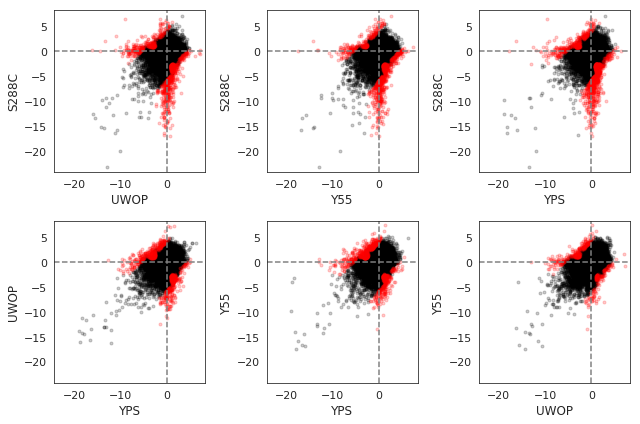

In [14]:
plt.figure(figsize=(9, 6))

vmin = min([d['scores1'].min(),
            d['scores2'].min()]) - 1
vmax = min([d['scores1'].max(),
            d['scores2'].max()]) + 1

ss = {tuple(x[:2])
      for x in d.index}
ss = sorted(ss, key=lambda x: x[1])

i = 1
for s1, s2 in ss:
    plt.subplot(2, 3, i)
    
    x = d.loc[(s1, s2),]
    plt.plot(x[x['qval'] >= 1E-2]['scores1'],
             x[x['qval'] >= 1E-2]['scores2'],
             'k.',
             alpha=0.2)
    plt.plot(x[x['qval'] < 1E-2]['scores1'],
             x[x['qval'] < 1E-2]['scores2'],
             'r.',
             alpha=0.2)
    
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    
    plt.axhline(0,
                color='grey',
                linestyle='dashed')
    plt.axvline(0,
                color='grey',
                linestyle='dashed')
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    
    i += 1

plt.tight_layout();

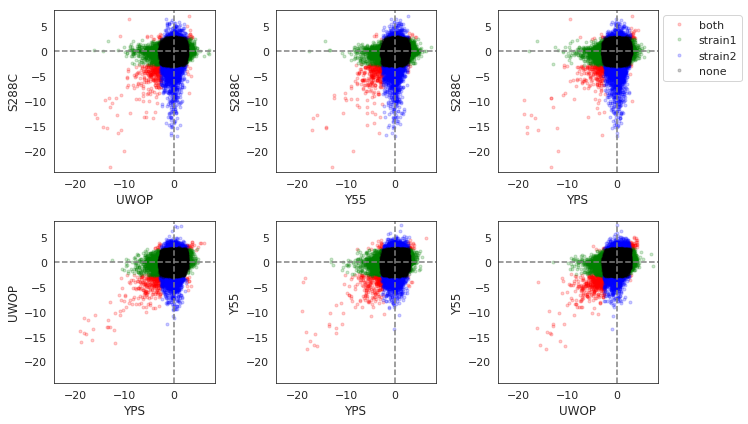

In [15]:
plt.figure(figsize=(10.5, 6))

vmin = min([d['scores1'].min(),
            d['scores2'].min()]) - 1
vmax = min([d['scores1'].max(),
            d['scores2'].max()]) + 1

ss = {tuple(x[:2])
      for x in d.index}
ss = sorted(ss, key=lambda x: x[1])

i = 1
for s1, s2 in ss:
    plt.subplot(2, 3, i)
    
    label1 = 'both'
    label2 = 'strain1'
    label3 = 'strain2'
    label4 = 'none'
    
    x = d.loc[(s1, s2),]
    plt.plot(x[x['phenotype1'] & x['phenotype2']]['scores1'],
             x[x['phenotype1'] & x['phenotype2']]['scores2'],
             'r.',
             alpha=0.2,
             label=label1)
    plt.plot(x[x['phenotype1'] & np.invert(x['phenotype2'])]['scores1'],
             x[x['phenotype1'] & np.invert(x['phenotype2'])]['scores2'],
             'g.',
             alpha=0.2,
             label=label2)
    plt.plot(x[x['phenotype2'] & np.invert(x['phenotype1'])]['scores1'],
             x[x['phenotype2'] & np.invert(x['phenotype1'])]['scores2'],
             'b.',
             alpha=0.2,
             label=label3)
    plt.plot(x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores1'],
             x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores2'],
             'k.',
             alpha=0.2,
             label=label4)
    
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    
    if i ==3:
        plt.legend(loc='upper left',
                   bbox_to_anchor=(1, 1),
                   frameon=True)
    
    plt.axhline(0,
                color='grey',
                linestyle='dashed')
    plt.axvline(0,
                color='grey',
                linestyle='dashed')
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    
    i += 1

plt.tight_layout();

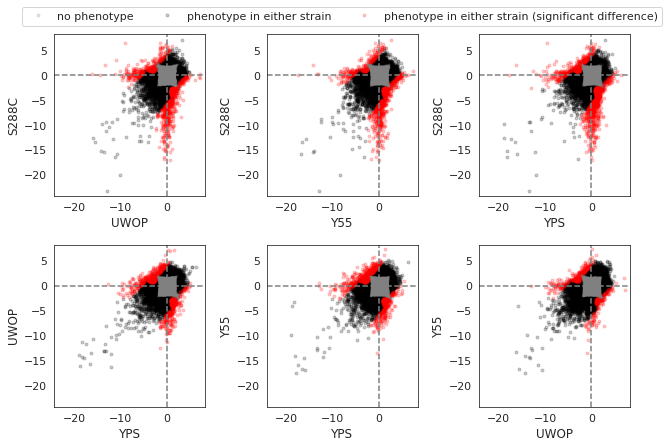

In [16]:
plt.figure(figsize=(9, 6))

vmin = min([d['scores1'].min(),
            d['scores2'].min()]) - 1
vmax = min([d['scores1'].max(),
            d['scores2'].max()]) + 1

ss = {tuple(x[:2])
      for x in d.index}
ss = sorted(ss, key=lambda x: x[1])

i = 1
for s1, s2 in ss:
    if i == 2:
        ax = plt.subplot(2, 3, i)
    else:
        plt.subplot(2, 3, i)
    
    label = 'no phenotype'
    label1 = 'phenotype in either strain'
    label2 = 'phenotype in either strain (significant difference)'
    
    x = d.loc[(s1, s2),]
    plt.plot(x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores1'],
             x[np.invert(x['phenotype1']) & np.invert(x['phenotype2'])]['scores2'],
             '.',
             color='grey',
             alpha=0.2,
             label=label)
    plt.plot(x[(x['qval'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores1'],
             x[(x['qval'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores2'],
             'k.',
             alpha=0.2,
             label=label1)
    plt.plot(x[(x['qval'] < 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores1'],
             x[(x['qval'] < 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores2'],
             'r.',
             alpha=0.2,
             label=label2)
    
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    
    plt.axhline(0,
                color='grey',
                linestyle='dashed')
    plt.axvline(0,
                color='grey',
                linestyle='dashed')
    
    plt.xlabel(s1)
    plt.ylabel(s2)
    
    i += 1

plt.tight_layout()
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, 1.2),
          frameon=True,
          ncol=3);

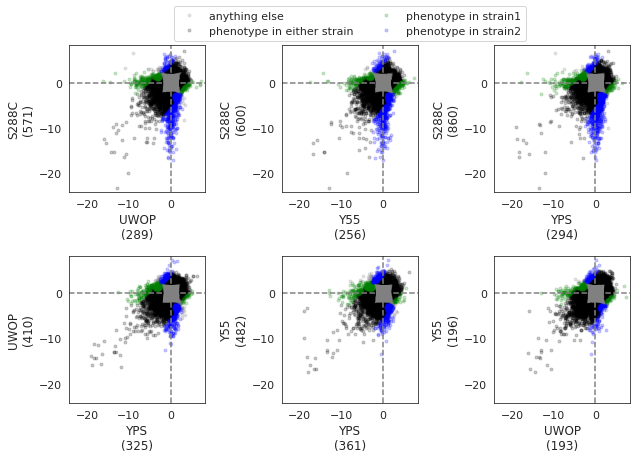

In [17]:
plt.figure(figsize=(9, 6))

vmin = min([d['scores1'].min(),
            d['scores2'].min()]) - 1
vmax = min([d['scores1'].max(),
            d['scores2'].max()]) + 1

ss = {tuple(x[:2])
      for x in d.index}
ss = sorted(ss, key=lambda x: x[1])

i = 1
for s1, s2 in ss:
    if i == 2:
        ax = plt.subplot(2, 3, i)
    else:
        plt.subplot(2, 3, i)
    
    label = 'anything else'
    label1 = 'phenotype in either strain'
    label2 = 'phenotype in strain1'
    label3 = 'phenotype in strain2'
    
    x = d.loc[(s1, s2),]
    idx1 = set(x[(x['qval'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])].index)
    idx2 = set(x[(x['qval'] < 1E-2) & (x['phenotype1'] & np.invert(x['phenotype2']))].index)
    idx3 = set(x[(x['qval'] < 1E-2) & (x['phenotype2'] & np.invert(x['phenotype1']))].index)
    idx = sorted(set(x.index) - idx1 - idx2 - idx3)
    plt.plot(x.loc[idx]['scores1'],
             x.loc[idx]['scores2'],
             '.',
             color='grey',
             alpha=0.2,
             label=label)
    plt.plot(x[(x['qval'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores1'],
             x[(x['qval'] >= 1E-2) & (x['phenotype1'] | x['phenotype2'])]['scores2'],
             'k.',
             alpha=0.2,
             label=label1)
    plt.plot(x[(x['qval'] < 1E-2) & (x['phenotype1'] & np.invert(x['phenotype2']))]['scores1'],
             x[(x['qval'] < 1E-2) & (x['phenotype1'] & np.invert(x['phenotype2']))]['scores2'],
             'g.',
             alpha=0.2,
             label=label2)
    plt.plot(x[(x['qval'] < 1E-2) & (x['phenotype2'] & np.invert(x['phenotype1']))]['scores1'],
             x[(x['qval'] < 1E-2) & (x['phenotype2'] & np.invert(x['phenotype1']))]['scores2'],
             'b.',
             alpha=0.2,
             label=label3)
    
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    
    plt.axhline(0,
                color='grey',
                linestyle='dashed')
    plt.axvline(0,
                color='grey',
                linestyle='dashed')
    
    plt.xlabel('%s\n(%d)' % (s1, len(idx2)))
    plt.ylabel('%s\n(%d)' % (s2, len(idx3)))
        
    i += 1

plt.tight_layout()

ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, 1.3),
          frameon=True,
          ncol=2);

In [18]:
res = []
for s1, s2 in sorted({tuple(x[:2])
                      for x in d.index},
                     key=lambda x: x[1]):
    v = d[d['phenotype1'] | d['phenotype2']].loc[(s1, s2),]
    idx = set(v.index)
    idx1 = set(v[v['phenotype1'] & np.invert(v['phenotype2']) & (v['qval'] < 1E-2)].index)
    idx2 = set(v[v['phenotype2'] & np.invert(v['phenotype1']) & (v['qval'] < 1E-2)].index)
    # switches
    idx3 = set(v[v['phenotype1'] & v['phenotype2'] & (v['qval'] < 1E-2)].index)
    idx = idx - idx1 - idx2 - idx3
    idx1 = idx1 - idx3
    idx2 = idx2 - idx3
    res.append(([len(idx1), len(idx), len(idx2), len(idx3)], [s1, s2]))

In [19]:
strains = {y
           for x in d.index
           for y in x[:2]}
palette = sns.color_palette('Set1', len(strains))
cstrains = {x: c
            for x,c in zip(strains, palette)}

/nfs/leia/research/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/nfs/leia/research/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/nfs/leia/research/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/nfs/leia/research/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/nfs/leia/research/beltrao/marco/software/anaconda3/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")
/nfs/leia/research/beltrao/marco/software/anaconda3/lib

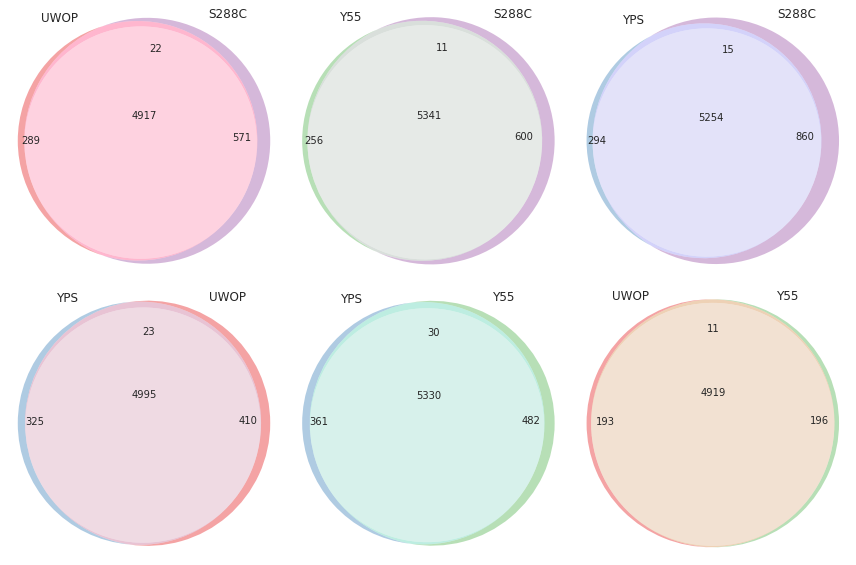

In [20]:
plt.figure(figsize=(12, 8))

for i, t in enumerate(res):
    plt.subplot(2, 3, i+1)
    
    (vs1, vs, vs2, vs3), (s1, s2) = t
    
    _ = venn3([vs1, vs2, vs3,
               0, 0, 0, vs],
              [s1, s2, ''],
              normalize_to=10,
              set_colors=[cstrains[s1],
                          cstrains[s2],
                          'w'])
plt.tight_layout()

In [49]:
x.loc[(slice(None), 'Doxorubicin (48H)'),]

,,scores1,scores2,sum,sub,phenotype1,phenotype2,var,mean,pval,qval
gene,condition,,,,,,,,,,
YAL004W,Doxorubicin (48H),3.281609,0.571998,3.853607,2.709610,True,False,0.847647,0.949330,1.891611e-02,0.527893
YAL010C,Doxorubicin (48H),3.913846,-0.577105,3.336741,4.490951,True,False,0.846124,0.948862,1.417997e-05,0.005345
YBR001C,Doxorubicin (48H),3.528374,0.108062,3.636436,3.420312,True,False,0.847647,0.949330,1.777825e-03,0.134296
YBR009C,Doxorubicin (48H),-4.345725,0.339650,-4.006075,4.685375,True,False,0.999840,1.815001,2.046954e-03,0.147326
YBR010W,Doxorubicin (48H),-0.447886,-3.902456,-4.350342,3.454570,False,True,0.999840,1.815001,5.052008e-02,0.837094
YBR098W,Doxorubicin (48H),-5.069338,-1.562665,-6.632003,3.506673,True,False,0.999840,1.815001,4.532840e-02,0.800031
YBR104W,Doxorubicin (48H),3.054232,1.341005,4.395237,1.713227,True,False,0.847647,0.949330,1.837417e-01,0.881279
YBR115C,Doxorubicin (48H),2.962899,-0.537780,2.425119,3.500679,True,False,0.842266,0.947819,1.218952e-03,0.106716
YBR131W,Doxorubicin (48H),3.696811,1.066326,4.763137,2.630485,True,False,0.847647,0.949330,2.366583e-02,0.592378


In [46]:
{x[1] for x in y.index}

{'2,4-Dichlorophenoxyacetic acid (48H)',
 '39ºC (48H)',
 '39ºC (72H)',
 '5-FU (48H)',
 '6-AU (48H)',
 '6-AU + 39ºC (48H)',
 '6-AU + 39ºC (72H)',
 'Acetic acid (48H)',
 'Amphotericin B (48H)',
 'Amphotericin B + anaerobic (48H)',
 'Anaerobic growth (48H)',
 'Cadmium chloride (48H)',
 'Caffeine 15mM (48H)',
 'Caffeine 20mM (48H)',
 'Caspofungin (48H)',
 'Caspofungin (72H)',
 'Clozapine (48H)',
 'Cyclohexamide (48H)',
 'DMSO 1%  (48H)',
 'Doxorubicin (48H)',
 'Glucose 20% (48H)',
 'Glycerol 2%  (48H)',
 'Glycerol 2%  (72H)',
 'Maltose 2%  (48H)',
 'NaCl 0.4M (48H)',
 'NaCl 0.4M + 39ºC (48H)',
 'NaCl 0.4M + 39ºC (72H)',
 'NaCl 0.6M (48H)',
 'NaCl 0.6M (72H)',
 'NaCl 0.6M + 39ºC (48H)',
 'NaCl 0.6M + 39ºC (72H)',
 'NiSO4 (48H)',
 'Nitrogen starvation (48H)',
 'Nystatin (48H)',
 'Paraquat (48H)',
 'Paraquat (72H)',
 'SC + hepes (48H)',
 'Sorbitol 1M (48H)',
 'aa starvation (48H)'}

In [42]:
res = []
for s1, s2 in sorted({tuple(x[:2])
                      for x in d.index},
                     key=lambda x: x[1]):
    y = d.loc[(s1, s2), ]
    
    p1 = y[y['phenotype1']].shape[0]
    p2 = y[y['phenotype2']].shape[0]

    x = y[(y['phenotype1']) | (y['phenotype2'])]
    
    sw = x[(x['phenotype1']) & (x['phenotype2']) & (np.sign(x['scores1']) != np.sign(x['scores2'])) & (x['qval'] < 0.01)].shape[0]
    
    e1 = x[(x['phenotype1']) & (x['qval'] < 0.01)].shape[0]
    e2 = x[(x['phenotype2']) & (x['qval'] < 0.01)].shape[0]
    
    sh1 = x[(x['phenotype1']) & (x['qval'] >= 0.01)].shape[0]
    sh2 = x[(x['phenotype2']) & (x['qval'] >= 0.01)].shape[0]
    
    res.append((s1, s2, y.shape[0], p1, sh1, e1, sw))
    res.append((s2, s1, y.shape[0], p2, sh2, e2, sw))

r = pd.DataFrame(res,
                 columns=['strain', 'other',
                          'scores',
                          'phenotypes',
                          'shared',
                          'exclusive',
                          'switches'])
r['pshared'] = r['shared'] / r['phenotypes']
r['pexclusive'] = r['exclusive'] / r['phenotypes']
r['pswitches'] = r['switches'] / r['phenotypes']

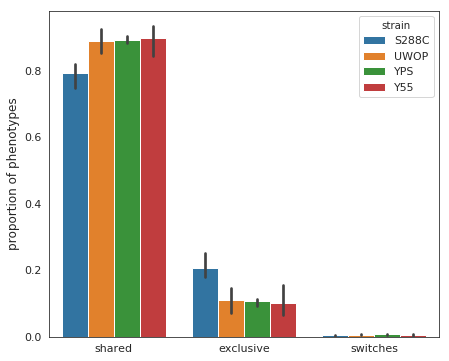

In [43]:
p = r.set_index(['strain',
                 'other']).stack()

p = p.to_frame().reset_index()
p.columns = ['strain',
             'other',
             'variable',
             'value']
p = p[p['variable'].isin(['pshared',
                          'pexclusive',
                          'pswitches'])]

plt.figure(figsize=(7, 6))

sns.barplot(x='variable',
            y='value',
            hue='strain',
            data=p,
            hue_order=r.groupby('strain').mean().sort_values('pshared').index)

plt.ylabel('proportion of phenotypes')
plt.xlabel('')

plt.xticks(range(3),
           ['shared', 'exclusive', 'switches']);

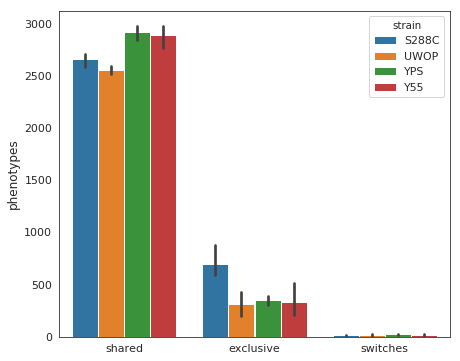

In [44]:
p = r.set_index(['strain',
                 'other']).stack()

p = p.to_frame().reset_index()
p.columns = ['strain',
             'other',
             'variable',
             'value']
p = p[p['variable'].isin(['shared',
                          'exclusive',
                          'switches'])]

plt.figure(figsize=(7, 6))

sns.barplot(x='variable',
            y='value',
            hue='strain',
            data=p,
            hue_order=r.groupby('strain').mean().sort_values('pshared').index)

plt.ylabel('phenotypes')
plt.xlabel('')

plt.xticks(range(3),
           ['shared', 'exclusive', 'switches']);

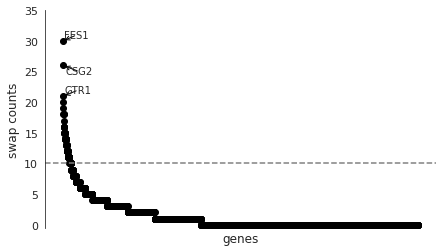

In [25]:
v = d.reset_index().set_index('gene').loc[genes]
v = v[v['qval'] < 0.01].groupby('gene').count()['qval'].sort_values(ascending=False)
v = v.reindex(genes)
v[np.isnan(v)] = 0.
v = v.sort_values(ascending=False)
idx = v.index

plt.figure(figsize=(7, 4))

plt.plot(range(v.shape[0]),
         v,
         'ko')

plt.axhline(10,
            linestyle='dashed',
            color='grey')

plt.ylim(-0.5, 35)

texts = [plt.text(i, y, gn.get(x, x),
                  ha='left',
                  va='center')
         for i,(x,y) in enumerate(v[v > 20].iteritems())]
adjust_text(texts,
            arrowprops=dict(arrowstyle='->',
                            color='k'),
            force_text=1.5)

plt.xticks([])
plt.ylabel('swap counts')
plt.xlabel('genes')
sns.despine(bottom=True);

In [26]:
res = []
t = 10
for g in v[v >= t].index:
    res.append(('above', it.get(g, 0)))
for g in v[v < t].sample(v[v >= t].shape[0]).index:
    res.append(('below', it.get(g, 0)))
igenes = sorted(gn.keys())
for i in range(10):
    random.shuffle(igenes)
    for g in igenes[:v[v >= t].shape[0]]:
        res.append(('random%d' % i, it.get(g, 0)))
r = pd.DataFrame(res,
                 columns=['set', 'interactions'])

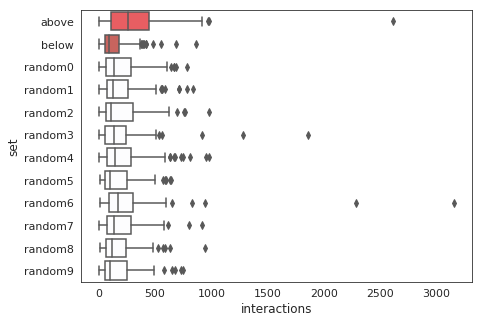

In [27]:
plt.figure(figsize=(7, 5))

sns.boxplot(data=r,
            x='interactions',
            y='set',
            palette=[sns.xkcd_rgb['light red'],
                     sns.xkcd_rgb['pale red']] + 
                    [sns.xkcd_rgb['pale grey']] * 10);

In [28]:
res = []
t = 10
for g in v[v >= t].index:
    res.append(('above', bc.get(g, 0)))
for g in v[v < t].sample(v[v >= t].shape[0]).index:
    res.append(('below', bc.get(g, 0)))
igenes = sorted(gn.keys())
for i in range(10):
    random.shuffle(igenes)
    for g in igenes[:v[v >= t].shape[0]]:
        res.append(('random%d' % i, bc.get(g, 0)))
r = pd.DataFrame(res,
                 columns=['set', 'interactions'])

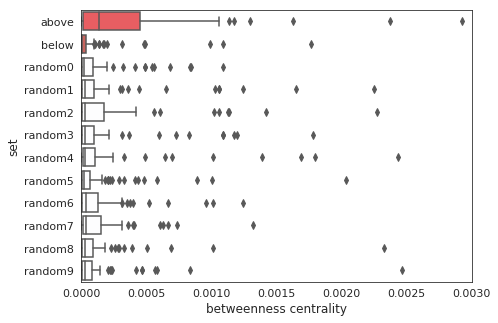

In [29]:
plt.figure(figsize=(7, 5))

sns.boxplot(data=r,
            x='interactions',
            y='set',
            palette=[sns.xkcd_rgb['light red'],
                     sns.xkcd_rgb['pale red']] + 
                    [sns.xkcd_rgb['pale grey']] * 10)
plt.xlim(0, 0.003)
plt.xlabel('betweenness centrality');

In [30]:
res = []
t = 10
for g in v[v >= t].index:
    res.append(('above', git.get(g, 0)))
for g in v[v < t].sample(v[v >= t].shape[0]).index:
    res.append(('below', git.get(g, 0)))
igenes = sorted(gn.keys())
for i in range(10):
    random.shuffle(igenes)
    for g in igenes[:v[v >= t].shape[0]]:
        res.append(('random%d' % i, git.get(g, 0)))
r = pd.DataFrame(res,
                 columns=['set', 'interactions'])

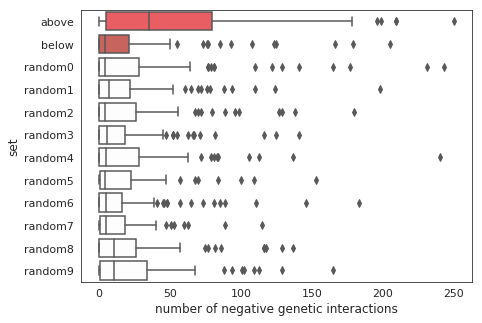

In [31]:
plt.figure(figsize=(7, 5))

sns.boxplot(data=r,
            x='interactions',
            y='set',
            palette=[sns.xkcd_rgb['light red'],
                     sns.xkcd_rgb['pale red']] + 
                    [sns.xkcd_rgb['pale grey']] * 10)
plt.xlabel('number of negative genetic interactions');

In [32]:
res = []
t = 10
for g in v[v >= t].index:
    res.append(('above', pit.get(g, 0)))
for g in v[v < t].sample(v[v >= t].shape[0]).index:
    res.append(('below', pit.get(g, 0)))
igenes = sorted(gn.keys())
for i in range(10):
    random.shuffle(igenes)
    for g in igenes[:v[v >= t].shape[0]]:
        res.append(('random%d' % i, pit.get(g, 0)))
r = pd.DataFrame(res,
                 columns=['set', 'interactions'])

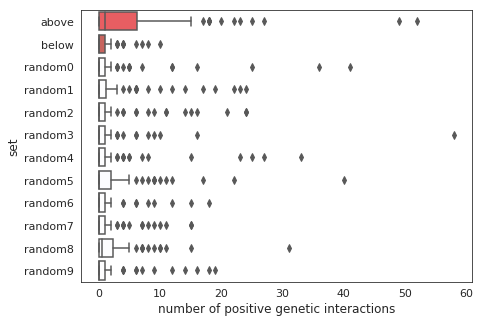

In [33]:
plt.figure(figsize=(7, 5))

sns.boxplot(data=r,
            x='interactions',
            y='set',
            palette=[sns.xkcd_rgb['light red'],
                     sns.xkcd_rgb['pale red']] + 
                    [sns.xkcd_rgb['pale grey']] * 10)
plt.xlabel('number of positive genetic interactions');

In [34]:
# mutfunc = mut.groupby('gene').max().to_dict()

In [35]:
# res = []
# t = 10
# for g in v[v >= t].index:
#     res.append(('above', mutfunc.get(g, 0)))
# for g in v[v < t].sample(v[v >= t].shape[0]).index:
#     res.append(('below', mutfunc.get(g, 0)))
# igenes = sorted(gn.keys())
# for i in range(5):
#     random.shuffle(igenes)
#     for g in igenes[:v[v >= t].shape[0]]:
#         res.append(('random%d' % i, mutfunc.get(g, 0)))
# r = pd.DataFrame(res,
#                  columns=['set', 'P(AF)'])

In [36]:
# plt.figure(figsize=(7, 3))

# sns.boxplot(data=r,
#             x='P(AF)',
#             y='set',
#             palette=[sns.xkcd_rgb['light red'],
#                      sns.xkcd_rgb['pale red']] + 
#                     [sns.xkcd_rgb['pale grey']] * 5)
# plt.xlabel('P(AF)');

In [37]:
# enrichment in negative interactions
enr = []
for studies in range(9):
    neg = set()
    for g1, g2 in gi[(gi['interaction'] == 'negative') &
                     (gi['count'] > studies)][['gene1', 'gene2']].values:
        neg.add(g1)
        neg.add(g2)
    pos = set()
    for g1, g2 in gi[(gi['interaction'] == 'positive') &
                     (gi['count'] > studies)][['gene1', 'gene2']].values:
        pos.add(g1)
        pos.add(g2)
    for count in [5, 10, 15]:
        table = [[len(v[v > count].index.intersection(neg)),
                  len(v[v <= count].index.intersection(neg))],
                 [len(v[v > count].index.difference(neg)),
                  len(v[v <= count].index.difference(neg))]]
        enr.append(('negative',
                    studies, count,
                    stats.fisher_exact(table,
                                       alternative='greater')[1]))
        table = [[len(v[v > count].index.intersection(pos)),
                  len(v[v <= count].index.intersection(pos))],
                 [len(v[v > count].index.difference(pos)),
                  len(v[v <= count].index.difference(pos))]]
        enr.append(('positive',
                    studies, count,
                    stats.fisher_exact(table,
                                       alternative='greater')[1]))
enr = pd.DataFrame(enr,
                   columns=['sign',
                            'gi_count',
                            'deviating_count',
                            'pvalue'])

In [38]:
vg = v.copy().to_frame()
vg['name'] = [gn.get(x, '')
              for x in vg.index]
vg['description'] = [gd.get(x, '')
                     for x in vg.index]
vg.columns = ['swaps', 'name', 'description']
vg.head(20)

,swaps,name,description
gene,,,
YBR101C,30.0,FES1,Hsp70 (Ssa1p) nucleotide exchange factor; requ...
YBR036C,26.0,CSG2,Endoplasmic reticulum membrane protein; requir...
YML121W,21.0,GTR1,Subunit of a TORC1-stimulating GTPase complex;...
YNR029C,20.0,,Putative protein of unknown function; deletion...
YDR126W,19.0,SWF1,Palmitoyltransferase that acts on transmembran...
YBR171W,18.0,SEC66,Non-essential subunit of Sec63 complex; with S...
YNL179C,18.0,,Dubious open reading frame; unlikely to encode...
YOR358W,18.0,HAP5,Subunit of the Hap2p/3p/4p/5p CCAAT-binding co...
YJL101C,17.0,GSH1,Gamma glutamylcysteine synthetase; catalyzes t...


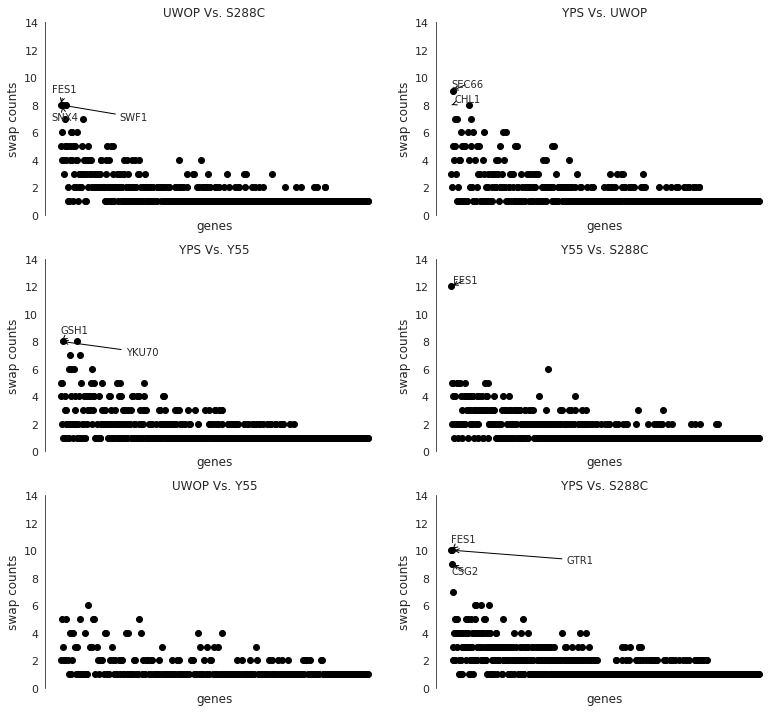

In [39]:
plt.figure(figsize=(11, 10))

i = 1
for s1, s2 in {tuple(x[:2])
               for x in d.index}:
    plt.subplot(3, 2, i)
    
    v = d.loc[(s1, s2), ].reset_index().set_index('gene').loc[genes]
    v = v[v['qval'] < 0.01].groupby('gene').count()['qval']
    v = v.reindex(idx).dropna()
    
    plt.plot(range(v.shape[0]),
         v,
         'ko')

    plt.ylim(0, 14)
    
    texts = [plt.text(i, y, gn.get(x, x),
                      ha='left',
                      va='center')
             for i,(x,y) in enumerate(v[v >= 8].iteritems())]
    adjust_text(texts,
                arrowprops=dict(arrowstyle='->',
                                color='k'),
                force_text=1.5)
    
    plt.xticks([])
    plt.ylabel('swap counts')
    plt.xlabel('genes')
    plt.title('%s Vs. %s' % (s1, s2))
    
    i += 1

plt.tight_layout()
sns.despine(bottom=True)

KeyError: "None of [Index(['Caffeine 15mM (48H)', 'aa starvation (48H)', 'Maltose 2%  (48H)',\n       'Acetic acid (48H)', 'Caspofungin (72H)', 'Glycerol 2%  (48H)',\n       'Cadmium chloride (48H)', 'NaCl 0.6M (72H)', 'NaCl 0.6M (48H)',\n       '2,4-Dichlorophenoxyacetic acid (48H)', 'Glycerol 2%  (72H)',\n       'NaCl 0.4M (48H)', '6-AU + 39ºC (48H)', 'Caffeine 20mM (48H)',\n       'NiSO4 (48H)', '6-AU + 39ºC (72H)', 'Paraquat (72H)',\n       'NaCl 0.6M + 39ºC (48H)', '5-FU (48H)', 'NaCl 0.6M + 39ºC (72H)',\n       'Cyclohexamide (48H)', 'Caspofungin (48H)', 'NaCl 0.4M + 39ºC (48H)',\n       '6-AU (48H)', '39ºC (48H)', 'Anaerobic growth (48H)',\n       'Doxorubicin (48H)', 'NaCl 0.4M + 39ºC (72H)', '39ºC (72H)',\n       'Maltose 2%  (72H)', 'Amphotericin B (48H)', 'SC + hepes (48H)',\n       'Glucose 20% (48H)', 'Amphotericin B + anaerobic (48H)',\n       'Clozapine (48H)', 'Paraquat (48H)', 'Sorbitol 1M (48H)',\n       'DMSO 1%  (48H)', 'Nitrogen starvation (48H)', 'Nystatin (48H)'],\n      dtype='object', name='condition')] are in the [index]"

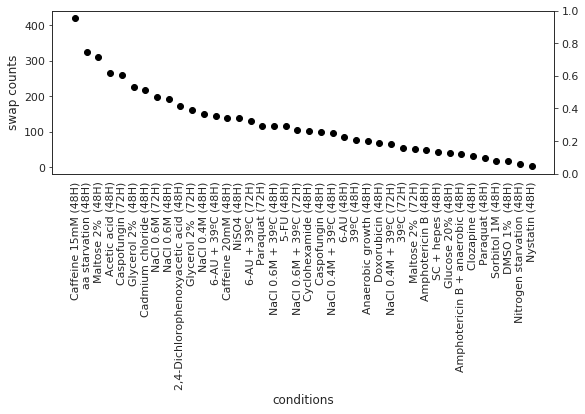

In [40]:
v = d.reset_index().set_index('gene').loc[genes]
v = v[v['qval'] < 0.01].groupby('condition').count()['qval'].sort_values(ascending=False)
idx = v.index

plt.figure(figsize=(9, 3))

plt.plot(range(v.shape[0]),
         v,
         'ko')

plt.xticks(range(v.shape[0]),
           v.index,
           rotation=90)
plt.ylabel('swap counts')
plt.xlabel('conditions')

plt.twinx()
plt.plot(range(v.shape[0]),
         v / p.loc[idx],
         'ro')

plt.tick_params('y', colors='r')
plt.ylabel('normalized swap counts',
           color='r')
plt.ylim(0, 1)

sns.despine(right=False,
            bottom=True);

In [ ]:
v = d.reset_index().set_index('gene').loc[genes]
v = v[v['qval'] < 0.01].groupby('condition').count()['qval'].sort_values(ascending=False)
idx = v.index
v1 = v / p.loc[idx]
v1 = v1.sort_values(ascending=False)
idx = v1.index
v = v.loc[idx]


plt.figure(figsize=(9, 3))

plt.plot(range(v.shape[0]),
         v,
         'ko')

plt.xticks(range(v.shape[0]),
           v.index,
           rotation=90)
plt.ylabel('swap counts')
plt.xlabel('conditions')

plt.twinx()
plt.plot(range(v.shape[0]),
         v / p.loc[idx],
         'ro')

plt.tick_params('y', colors='r')
plt.ylabel('normalized swap counts',
           color='r')
plt.ylim(0, 1)

sns.despine(right=False,
            bottom=True);

In [ ]:
plt.figure(figsize=(11, 10))

i = 1
for s1, s2 in {tuple(x[:2])
               for x in d.index}:
    plt.subplot(3, 2, i)
    
    v = d.loc[(s1, s2), ].reset_index().set_index('gene').loc[genes]
    v = v[v['qval'] < 0.01].groupby('condition').count()['qval']
    v = v.reindex(idx).dropna()
    
    plt.plot(range(v.shape[0]),
         v,
         'ko')

    plt.ylim(0, 160)
    
    plt.xticks([])
    plt.ylabel('swap counts')
    plt.xlabel('conditions')
    
    plt.twinx()
    plt.plot(range(v.shape[0]),
             v / p.loc[v.index],
             'ro')

    plt.tick_params('y', colors='r')
    plt.ylabel('normalized swap counts',
               color='r')
    plt.ylim(0, 1)
    
    plt.title('%s Vs. %s' % (s1, s2))
    
    i += 1

plt.tight_layout()
sns.despine(right=False,
            bottom=True);